In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split

import string
import warnings
warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
warnings.warn = warn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from scipy.stats import skew,boxcox  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from vecstack import stacking

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from math import sqrt
pd.set_option('display.max_columns', 100)


# 1 Data Loading

In [2]:
raw_analysis = pd.read_csv('./analysisData.csv')
raw_scoring = pd.read_csv('./scoringData.csv')

def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_train = raw_analysis.copy()
df_test = raw_scoring.copy()
df_all = concat_df(df_train, df_test)

print('The shape of training set: {}'.format(df_train.shape))
print('The shape of test set: {}'.format(df_test.shape))
print('The shape of ALL set: {}'.format(df_all.shape))

The shape of training set: (36839, 91)
The shape of test set: (9210, 90)
The shape of ALL set: (46049, 91)


In [3]:
y = df_train.loc[:,['price']]

In [4]:
y.shape

(36839, 1)

# 2 Feature Selection 

In [5]:
columns_keep = [
               # 'amenities',
                'accommodates','bathrooms','bedrooms','beds','bed_type',
                'cancellation_policy','cleaning_fee','extra_people','host_response_time',
                'host_has_profile_pic','guests_included',
                'review_scores_value', 'reviews_per_month', 'room_type','property_type',
                'security_deposit','zipcode'
               ]

X_all = df_all.loc[:, columns_keep]

# 3 Data Cleaning

In [6]:
X_all.beds = X_all.beds.fillna(X_all.beds.median())
X_all.reviews_per_month = X_all.reviews_per_month.fillna(X_all.reviews_per_month.median())

X_all['cleaning_fee_missing'] = X_all.cleaning_fee.isna()
X_all.cleaning_fee = X_all.cleaning_fee.fillna(X_all.cleaning_fee.median())

X_all.host_has_profile_pic = X_all.host_has_profile_pic.fillna(0)

X_all['security_deposit_missing']  = X_all.security_deposit.isna()
X_all.security_deposit = X_all.groupby(['beds','room_type'])['security_deposit'].apply(lambda x:x.fillna(x.median()))
X_all.security_deposit = X_all.security_deposit.fillna(X_all.security_deposit.median())

X_all['host_response_time_missing'] = X_all.host_response_time.isna()
X_all.host_response_time = X_all.host_response_time.fillna('missing')

In [7]:
def int_transform(x):
    try: 
        if type(x)==str:
            value = int(x[0:5])
        else:
            value = int(x)
    except:
        value = 0
    return value

X_all.zipcode = X_all.zipcode.apply(int_transform)
X_all['zipcode_missing'] = (X_all.zipcode==0)

In [8]:
X_all.isnull().sum().sum()

0

# 4 Feature Engineering

#### 4.1 Skewness 

In [9]:
#continuous_features = ['cleaning_fee','reviews_per_month','security_deposit']
numerical_features = [
                        'extra_people','bathrooms','guests_included',
                        'beds','accommodates','bedrooms','cleaning_fee',
                        'reviews_per_month',
                        'review_scores_value'
                     ]
numerical_features
skewness_features = X_all.loc[:,numerical_features].skew().sort_values(ascending=False)
skewness_features


extra_people           4.200536
bathrooms              4.133438
guests_included        3.449794
beds                   3.032778
accommodates           2.298120
bedrooms               2.142594
cleaning_fee           1.988105
reviews_per_month      1.975462
review_scores_value   -2.961109
dtype: float64

In [10]:
from scipy.stats import boxcox
for i in skewness_features.index:
        df_tmp = X_all[i].apply(lambda x:x+0.00001)
        try:
            X_all[i],lmbda = boxcox(df_tmp,lmbda=None)
        except:
            print(i)

In [11]:
skewness_features = X_all.loc[:,numerical_features].skew().sort_values(ascending=False)
skewness_features

bathrooms              1.216900
guests_included        0.805711
beds                   0.306492
accommodates           0.008074
reviews_per_month     -0.071370
extra_people          -0.130002
cleaning_fee          -0.443801
review_scores_value   -0.485133
bedrooms              -0.758570
dtype: float64

#### 4.2 Text Processing

#### 4.3 Label Encoding

In [12]:
cate_features = [
                 'bed_type','cancellation_policy','host_response_time',
                 'room_type', 'property_type', 'host_has_profile_pic'
                ]
le = LabelEncoder()
for feat in cate_features:
    try:
        X_all[feat] = le.fit_transform(X_all[feat].astype(str))
    except: 
        print(feat)
    

In [13]:
X_all.sample(3)

,accommodates,bathrooms,bedrooms,beds,bed_type,cancellation_policy,cleaning_fee,extra_people,host_response_time,host_has_profile_pic,guests_included,review_scores_value,reviews_per_month,room_type,property_type,security_deposit,zipcode,cleaning_fee_missing,security_deposit_missing,host_response_time_missing,zipcode_missing
9836,1.210023,0.438804,0.830319,0.809455,4,0,9.586887,-9.904005,4,2,0.000010,4.739445e+06,0.736748,1,20,100.0,11354,True,True,False,False
3590,0.647063,0.438804,0.830319,0.000010,4,1,10.062005,4.124787,1,2,0.338029,2.138359e+06,-0.072103,0,1,200.0,11215,False,False,True,False
33871,0.000010,0.000010,0.000010,0.000010,4,3,3.808313,3.005445,4,2,0.000010,4.739445e+06,0.260384,1,1,180.0,10009,False,False,False,False


#### 4.4 OneHot and Not OneHot

In [14]:
X_all1 = X_all.copy()
X_all2 = X_all.copy()

onehot_features = [
                    'bed_type', 'cancellation_policy','host_response_time',
                    'room_type', 'property_type',
                    'host_has_profile_pic', 'zipcode'
                  ]

for feat in onehot_features:
    dummy_col = pd.get_dummies(X_all1[feat], prefix=feat)
    X_all1 = pd.concat([X_all1, dummy_col],axis=1)

X_all1 = X_all1.drop(onehot_features, axis=1)

In [15]:
X_all1.sample(3)

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,extra_people,guests_included,review_scores_value,reviews_per_month,security_deposit,cleaning_fee_missing,security_deposit_missing,host_response_time_missing,zipcode_missing,bed_type_0,bed_type_1,bed_type_2,bed_type_3,bed_type_4,cancellation_policy_0,cancellation_policy_1,cancellation_policy_2,cancellation_policy_3,cancellation_policy_4,cancellation_policy_5,host_response_time_0,host_response_time_1,host_response_time_2,host_response_time_3,host_response_time_4,room_type_0,room_type_1,room_type_2,property_type_0,property_type_1,property_type_2,property_type_3,property_type_4,property_type_5,property_type_6,property_type_7,property_type_8,property_type_9,property_type_10,property_type_11,property_type_12,property_type_13,property_type_14,property_type_15,property_type_16,...,zipcode_11357,zipcode_11358,zipcode_11360,zipcode_11361,zipcode_11362,zipcode_11363,zipcode_11364,zipcode_11365,zipcode_11366,zipcode_11367,zipcode_11368,zipcode_11369,zipcode_11370,zipcode_11372,zipcode_11373,zipcode_11374,zipcode_11375,zipcode_11377,zipcode_11378,zipcode_11379,zipcode_11385,zipcode_11411,zipcode_11412,zipcode_11413,zipcode_11414,zipcode_11415,zipcode_11416,zipcode_11417,zipcode_11418,zipcode_11419,zipcode_11420,zipcode_11421,zipcode_11422,zipcode_11423,zipcode_11426,zipcode_11427,zipcode_11428,zipcode_11429,zipcode_11432,zipcode_11433,zipcode_11434,zipcode_11435,zipcode_11436,zipcode_11559,zipcode_11580,zipcode_11691,zipcode_11692,zipcode_11693,zipcode_11694,zipcode_91766
14739,1.210023,0.00001,0.00001,0.000010,8.543815,3.119466,0.338029,4.739445e+06,0.292391,300.0,False,False,False,False,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19215,1.504776,0.00001,1.46956,1.904934,13.500296,-9.904005,0.411586,2.138359e+06,1.462671,100.0,False,False,False,False,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43313,0.985847,0.00001,0.00001,0.000010,9.586887,-9.904005,0.000010,4.739445e+06,-1.330823,200.0,True,True,True,False,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
# make sure features name unique
len(set(X_all1.columns))

265

#### 4.5 Max-min Scaling

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
X_all1 = pd.DataFrame(data = scaler.fit_transform(X_all1),
                      columns = X_all1.columns)
X_all2 = pd.DataFrame(data = scaler.fit_transform(X_all2),
                      columns = X_all2.columns)
X_all1.sample(3)

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,extra_people,guests_included,review_scores_value,reviews_per_month,security_deposit,cleaning_fee_missing,security_deposit_missing,host_response_time_missing,zipcode_missing,bed_type_0,bed_type_1,bed_type_2,bed_type_3,bed_type_4,cancellation_policy_0,cancellation_policy_1,cancellation_policy_2,cancellation_policy_3,cancellation_policy_4,cancellation_policy_5,host_response_time_0,host_response_time_1,host_response_time_2,host_response_time_3,host_response_time_4,room_type_0,room_type_1,room_type_2,property_type_0,property_type_1,property_type_2,property_type_3,property_type_4,property_type_5,property_type_6,property_type_7,property_type_8,property_type_9,property_type_10,property_type_11,property_type_12,property_type_13,property_type_14,property_type_15,property_type_16,...,zipcode_11357,zipcode_11358,zipcode_11360,zipcode_11361,zipcode_11362,zipcode_11363,zipcode_11364,zipcode_11365,zipcode_11366,zipcode_11367,zipcode_11368,zipcode_11369,zipcode_11370,zipcode_11372,zipcode_11373,zipcode_11374,zipcode_11375,zipcode_11377,zipcode_11378,zipcode_11379,zipcode_11385,zipcode_11411,zipcode_11412,zipcode_11413,zipcode_11414,zipcode_11415,zipcode_11416,zipcode_11417,zipcode_11418,zipcode_11419,zipcode_11420,zipcode_11421,zipcode_11422,zipcode_11423,zipcode_11426,zipcode_11427,zipcode_11428,zipcode_11429,zipcode_11432,zipcode_11433,zipcode_11434,zipcode_11435,zipcode_11436,zipcode_11559,zipcode_11580,zipcode_11691,zipcode_11692,zipcode_11693,zipcode_11694,zipcode_91766
38692,0.000000,0.446397,0.224753,0.263437,0.189383,0.000000,0.0,0.451180,0.146238,0.1001,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44108,0.569165,0.446397,0.224753,0.263437,0.528888,0.000000,0.0,0.185329,0.446069,0.2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7240,0.463717,0.446397,0.224753,0.000000,0.364475,0.764226,0.0,0.451180,0.393520,0.1001,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
X_all2.sample(3)

,accommodates,bathrooms,bedrooms,beds,bed_type,cancellation_policy,cleaning_fee,extra_people,host_response_time,host_has_profile_pic,guests_included,review_scores_value,reviews_per_month,room_type,property_type,security_deposit,zipcode,cleaning_fee_missing,security_deposit_missing,host_response_time_missing,zipcode_missing
7856,0.304360,0.446397,0.224753,0.263437,1.0,0.6,0.274964,0.825641,0.75,1.0,0.000000,0.451180,0.491660,0.5,0.030303,0.100100,0.109180,0.0,0.0,0.0,0.0
9487,0.569165,0.764687,0.224753,0.426635,1.0,0.6,0.274964,0.764226,0.25,1.0,0.811123,0.451180,0.606155,0.5,0.030303,0.100100,0.122224,0.0,1.0,1.0,0.0
9975,0.707811,0.446397,0.319496,0.483958,1.0,0.6,0.405487,0.838042,1.00,1.0,0.987633,0.185329,0.667883,0.0,0.606061,0.800801,0.123935,0.0,0.0,0.0,0.0


In [19]:
print(X_all2.shape)

(46049, 21)


# 5 X, X_test split
##### Now:  X_all -> X + X_test 
##### Later:......... -> (X_train+X_dev) + X_test

In [20]:
X1, X_test1 = X_all1.iloc[0:36839], X_all1.iloc[36839:] 
X2, X_test2 = X_all2.iloc[0:36839], X_all2.iloc[36839:]
print(X1.shape)
print(X_test1.shape)
print(X2.shape)
print(X_test2.shape)

(36839, 265)
(9210, 265)
(36839, 21)
(9210, 21)


# 6 Model Selection
##### train X_train, predict X_dev

#### 6.1 Core training pipeline function

In [27]:
def Get_Best_Model(X_train, X_dev, y_train, y_dev):
    kfolds = KFold(n_splits=3, shuffle=True, random_state=25)
    
    #######################
    #######################
    
    alphas_ridge = [1e-6,1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,0.1,0.5,1,5,10,20,100,1000] # :05
    alphas_lasso = [1e-6,1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,0.1,0.5,1,5,10,20,100,1000] # :05
    e_alphas = [1e-6,1e-5,1e-3,0.1,1,10,100] # 1:30
    e_l1ratio = [0.01,0.1,0.4,0.6,0.9,0.99]
    
    param_GB = {'min_samples_leaf': [1,2,5,10,20],
                'max_depth': [3,4],
                'max_features': ['sqrt'],
                'learning_rate': [0.001,0.05,0.1,0.2],
                'criterion': ['mse'],
                'n_estimators': [300,1000]
               }#3min
    #{'n_estimators': [100]} # :30
    param_LGBM = {'n_estimators':[200,800,2000],
                  'num_leaves':[15,31,50],
                  'max_depth': [-1,3,4,6],
                  'learning_rate': [0.001,0.01,0.05,0.1,0.5]
                 } # 60min
    #{'n_estimators': [100]} # :05
    param_XGB = {'n_estimators': [500],
                 'learning_rate': [0.001,0.1,0.1,0.5] ,
                 'max_depth': [2,3,4]
                } #30 min
    #{'n_estimators': [100]} # :50
    param_RF = {'n_estimators': [400,1000],
                'min_samples_leaf':[1,5,10],
                'max_features': ['sqrt',None],
                'max_depth': [3,None],
                'warm_start':[True]
               } # need increase
    #{'n_estimators': [100]} # 4:10
    param_NN = {'hidden_layer_sizes':[(102,),(11,),(132,50),(13,5)],
                'learning_rate_init':[0.001,0.01],
                'max_iter': [200],
                'alpha': [0.001,0.5,2,7],
                'activation':['relu']
               } #80 min
    #{'activation': ['relu']} # 2:30
    param_Stack = {'hidden_layer_sizes':[(3,),(2,)],
                   'learning_rate_init':[0.0001,0.001,0.01,0.1]
                  } # 6 min
    #{'activation': ['relu']} # 0:15

    
    #CV1:10 min
    #CV2:1.5min
    
    #######################
    #====GridSearchCV=====#

    
#     ridge = RidgeCV(
#                     alphas=alphas_ridge, 
#                     cv=kfolds,
#                     scoring = 'neg_mean_squared_error',
#                    )
    
#     lasso = LassoCV(
#                     max_iter = 1e7, 
#                     alphas = alphas_lasso,
#                     cv = kfolds
#                    )
    
#     elasticnet = ElasticNetCV(
#                               max_iter = 1e5, 
#                               alphas = e_alphas,
#                               cv=kfolds, 
#                               l1_ratio=e_l1ratio
#                              )
    
    GB = GridSearchCV(
                      GradientBoostingRegressor(),
                      param_grid = param_GB,
                      cv = kfolds,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1
                     )
    LGBM = GridSearchCV(
                      LGBMRegressor(objective='regression'),
                      param_grid = param_LGBM,
                      cv = kfolds,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1
                     )
    XGB = GridSearchCV(
                      XGBRegressor(),
                      param_grid = param_XGB,
                      cv = kfolds,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1
                     )
    RF = GridSearchCV(
                      RandomForestRegressor(),
                      param_grid = param_RF,
                      cv = kfolds,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1
                     )
    NN = GridSearchCV(
                      MLPRegressor(),
                      param_grid = param_NN,
                      cv = kfolds,
                      n_jobs = -1
                     )
        
    Models = [GB, XGB] #[ridge, lasso, elasticnet, GB, LGBM, XGB, RF, NN]
    Model_names = ['GB','XGB','Stack']#['ridge','lasso','elasticnet','GB','LGBM','XGB','RF','NN','Stack']
    #######################
    #######################
    #===== Training ======#
    y_train_Predict = []
    y_dev_Predict = []
    
    for i in range(len(Models)):
        print(datetime.now(), 'Training Models: ', Model_names[i])
        try:
            Models[i].fit(X_train, y_train)
            print(datetime.now(),'Predicting Models ', Model_names[i])
            y_train_Predict.append(Models[i].predict(X_train).reshape(1,len(X_train))[0])
            y_dev_Predict.append(Models[i].predict(X_dev).reshape(1,len(X_dev))[0])
            print('Model ', Model_names[i], ' has rmse = ',sqrt(mean_squared_error(y_dev_Predict[i], y_dev)))
        except:
            Models[0].fit(X_train, y_train)
            print(datetime.now(),'Error Replace Model with ', Model_names[0])
            y_train_Predict.append(Models[0].predict(X_train).reshape(1,len(X_train))[0])
            y_dev_Predict.append(Models[0].predict(X_dev).reshape(1,len(X_dev))[0])
            print('Error Model has rmse = ',sqrt(mean_squared_error(y_dev_Predict[i], y_dev)))

    #######################
    #######################
    #=======Stacking======#
    print(datetime.now(),'Stack')
    
    S_train = np.transpose(y_train_Predict)
    S_dev = np.transpose(y_dev_Predict)
    Stack = GridSearchCV(
                         MLPRegressor(),
                         param_grid = param_Stack,
                         cv=5,
                         n_jobs = -1
                         )
    Stack.fit(S_train, y_train)
    y_train_Predict.append(Stack.predict(S_train))
    y_dev_Predict.append(Stack.predict(S_dev).reshape(1,len(X_dev))[0])
    print('rmse: ', sqrt(mean_squared_error(y_dev_Predict[-1], y_dev)))
    Models.append(Stack)
    
    #######################
    #######################
    #=======Selection=====#
    print(datetime.now(),'Start Selecting')
    
    RMSE = []
    for i in range(len(y_dev_Predict)):
        rmse = sqrt(mean_squared_error(y_dev_Predict[i], y_dev))
        RMSE.append(rmse)
        #print('Model ', Model_names[i], ' has rmse = ', RMSE[i])

    idx = np.argmin(RMSE)
    print(datetime.now(),'BestModel:', Model_names[idx])
    return Models[idx], RMSE[idx], Models[0],Models[1],Models[2]
    

#### 6.2 Global CV for X_train X_dev split

In [53]:
list(BM2.keys())[0].best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [26]:
list(BM2.keys())[0].best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2000, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [31]:
M4.best_estimator_

In [ ]:
# X_train, X_dev, y_train, y_dev = train_test_split(X2,y,
#                                                   test_size=9210, 
#                                                   random_state = 1)

M1 = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                   importance_type='split', learning_rate=0.01, max_depth=-1,
                   min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                   n_estimators=4000, n_jobs=-1, num_leaves=31,
                   objective='regression', random_state=None, reg_alpha=0.0,
                   reg_lambda=0.0, silent=True, subsample=1.0,
                   subsample_for_bin=200000, subsample_freq=0)
M2 = GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=20, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
M3 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
param_Stack = {'hidden_layer_sizes':[(3,),(2,),(2,2)],
               'learning_rate_init':[0.0001,0.001,0.01,0.1,0.5]
              } # 6 min
Stack = GridSearchCV(
                      MLPRegressor(),
                      param_grid = param_Stack,
                      cv = 5,
                      n_jobs = -1
                     )
Models = [M1,M2,M3]

y_train_Predict = []
y_dev_Predict = []

for i in range(len(Models)):
        print(datetime.now())
        Models[i].fit(X_train, y_train)
        print(datetime.now(),'Predicting Models ')
        y_train_Predict.append(Models[i].predict(X_train).reshape(1,len(X_train))[0])
        y_dev_Predict.append(Models[i].predict(X_dev).reshape(1,len(X_dev))[0])
        print('Model has rmse = ',sqrt(mean_squared_error(y_dev_Predict[i], y_dev)))


S_train = np.transpose(y_train_Predict)
S_dev = np.transpose(y_dev_Predict)
Stack.fit(S_train, y_train)
y_train_Predict.append(Stack.predict(S_train))
y_dev_Predict.append(Stack.predict(S_dev).reshape(1,len(X_dev))[0])
print('rmse: ', sqrt(mean_squared_error(y_dev_Predict[-1], y_dev)))

#### 6.3 Best Model Picking 

In [ ]:
BESTMODEL = 
X_BEST = #  X1 ? X2
X_test_BEST = # X_test1 ? X_test2 

# 7 Final Prediction and Submit 
##### train X, predict X_test 

In [34]:
X = X2
X_test = X_test2

M1 = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                   importance_type='split', learning_rate=0.01, max_depth=-1,
                   min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                   n_estimators=10000, n_jobs=-1, num_leaves=31,
                   objective='regression', random_state=None, reg_alpha=0.0,
                   reg_lambda=0.0, silent=True, subsample=1.0,
                   subsample_for_bin=200000, subsample_freq=0)
M2 = GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=20, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
M3 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=8000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
param_Stack = {'hidden_layer_sizes':[(3,),(2,),(2,2)],
               'learning_rate_init':[0.0001,0.001,0.01,0.1,0.3,0.5,0.9]
              } # 6 min
Stack = GridSearchCV(
                      MLPRegressor(),
                      param_grid = param_Stack,
                      cv = 5,
                      n_jobs = -1
                     )
Models = [M1,M2,M3]

y_Predict = []
y_test_Predict = []

for i in range(len(Models)):
        print(datetime.now())
        Models[i].fit(X, y)
        print(datetime.now(),'Predicting Models ')
        y_Predict.append(Models[i].predict(X).reshape(1,len(X))[0])
        y_test_Predict.append(Models[i].predict(X_test).reshape(1,len(X_test))[0])
        print('Model has training rmse = ',sqrt(mean_squared_error(y_Predict[i], y)))



S = np.transpose(y_Predict)
S_test = np.transpose(y_test_Predict)
Stack.fit(S, y)
print('Stack Model has training rmse = ',sqrt(mean_squared_error(Stack.predict(S), y)))
y_final = Stack.predict(S_test) #.reshape(1,len(X_test))[0])


2019-11-17 10:49:53.194203
2019-11-17 10:50:28.802841 Predicting Models 
Model has training rmse =  37.83512350212674
2019-11-17 10:51:43.389652


KeyboardInterrupt: 

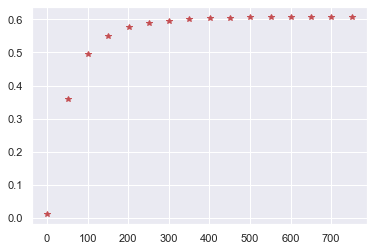

In [61]:
M1 = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                   importance_type='split', learning_rate=0.01, max_depth=-1,
                   min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                   n_estimators=700, n_jobs=-1, num_leaves=31,
                   objective='regression', random_state=None, reg_alpha=0.0,
                   reg_lambda=0.0, silent=True, subsample=1.0,
                   subsample_for_bin=20000, subsample_freq=0)
M3 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
score = []
for i in range(1,800,50):
    M1 = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                   importance_type='split', learning_rate=0.01, max_depth=-1,
                   min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
                   n_estimators=i, n_jobs=-1, num_leaves=40,
                   objective='regression', random_state=None, reg_alpha=0.0,
                   reg_lambda=0.0, silent=True, subsample=1.0,
                   subsample_for_bin=15, subsample_freq=0)
    score.append(np.mean(cross_val_score(M1,X,y,cv=3)))
plt.plot(range(1,800,50),score, 'r*')

In [40]:
# BESTMODEL.fit(X_BEST)
# y_final = BESTMODEL.predict(X_BEST)

result_df = pd.DataFrame(columns=['id','price'])
result_df['id'] = df_test.id
result_df['price'] = y_final
result_df = result_df.astype(int)
result_df.to_csv('submissions.csv', index=False)
result_df

,id,price
0,23136,115
1,37597,151
2,38982,163
3,42288,63
4,45375,78
5,47609,136
6,48740,121
7,48850,138
8,49205,59
9,49786,153
